In [1]:
import os
import warnings
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go


import matplotsoccer as mps # 축구 이벤트 데이터 시각화
from socceraction.data.statsbomb import StatsBombLoader # StatsBomb 데이터 로더
import socceraction.spadl as spadl # SPADL 포맷 변환 및 처리
import socceraction.xthreat as xthreat # Expected Threat (xT) 계산

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up the StatsBombLoader

In [ ]:
# StatsBomb 데이터 로더 객체를 생성합니다. 무료 공개 데이터 접근을 위해 creds를 None으로 설정합니다.
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})
SBL

In [ ]:
# 사용 가능한 대회 목록
competitions = SBL.competitions()
competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,281,9,1. Bundesliga,Germany,male,2023/2024
1,27,9,1. Bundesliga,Germany,male,2015/2016
2,107,1267,African Cup of Nations,Africa,male,2023
3,4,16,Champions League,Europe,male,2018/2019
4,1,16,Champions League,Europe,male,2017/2018
...,...,...,...,...,...,...
70,75,35,UEFA Europa League,Europe,male,1988/1989
71,315,53,UEFA Women's Euro,Europe,female,2025
72,106,53,UEFA Women's Euro,Europe,female,2022
73,107,72,Women's World Cup,International,female,2023


In [ ]:
# 'FIFA World Cup' 2018 시즌
selected_competitions = competitions[
	(competitions.competition_name == "FIFA World Cup")
	& (competitions.season_name == "2018")
]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
30,3,43,FIFA World Cup,International,male,2018


In [6]:
games = pd.concat([
	SBL.games(row.competition_id, row.season_id)
	for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,769,768,2018-07-03 20:00:00,1,1
1,768,782,2018-06-28 20:00:00,0,1
2,790,773,2018-07-03 16:00:00,1,0
3,797,780,2018-06-25 20:00:00,1,1
4,780,788,2018-06-20 14:00:00,1,0
...,...,...,...,...,...
59,796,774,2018-06-19 20:00:00,3,1
60,796,785,2018-07-07 20:00:00,2,2
61,776,771,2018-06-26 16:00:00,0,0
62,778,787,2018-06-24 17:00:00,2,2


### 🥅 SPADL (Soccer Player Action Description Language) 전처리 및 로딩

- SPADL: StatsBomb, Opta, Wyscout 등 다양한 데이터 제공 업체의 서로 다른 이벤트 데이터 포맷을 통일된 액션 기반 포맷으로 변환하는 언어입니다.
- 현대 축구 데이터 분석 연구에서는 SPADL이라는 통일된 포맷을 사용하여 분석하는 연구가 주를 이룹니다.
- 주요 정보: 액션 유형, 시작/종료 좌표, 선수, 팀, 결과 등
- [논문링크](https://dl.acm.org/doi/10.1145/3292500.3330758)
- [Github](https://github.com/ML-KULeuven/socceraction/tree/master)

In [ ]:
# 모든 액션이 왼쪽에서 오른쪽으로 진행되도록 좌표를 변환하는 함수입니다.
# xT 모델은 공격 방향을 통일해야 합니다. 
def play_left_to_right(actions: pd.DataFrame, home_team_id: int) -> pd.DataFrame:
	"""
		모든 액션이 동일한 경기 방향(왼쪽에서 오른쪽)으로 수행되도록 변환합니다.

		이 함수는 각 액션의 시작 및 종료 위치를 변경하여,
		마치 첫 액션을 수행한 팀이 항상 왼쪽에서 오른쪽으로 플레이하는 것처럼 만듭니다.

		Parameters
		----------
		actions : pd.DataFrame
			한 경기의 액션 데이터프레임.
		home_team_id : int
			홈팀의 ID.

		Returns
		-------
		pd.DataFrame
			모든 액션이 왼쪽에서 오른쪽으로 수행되도록 좌표가 변환된 데이터프레임.
	"""

	away_idx = actions.team_id != home_team_id

	for col in ["start_x", "end_x"]:
		actions.loc[away_idx, col] = spadl.config.field_length - actions[away_idx][col].values
	for col in ["start_y", "end_y"]:
		actions.loc[away_idx, col] = spadl.config.field_width - actions[away_idx][col].values

	return actions

In [ ]:
games_verbose = tqdm(list(games.itertuples()), desc="Loading game data")
df_teams, df_players, df_actions = [], [], []

for game in games_verbose:
	# load data
	df_teams.append(SBL.teams(game.game_id))
	df_players.append(SBL.players(game.game_id))
	events = SBL.events(game.game_id)
	
	# StatsBomb 이벤트 데이터를 SPADL 액션 데이터로 변환합니다.
	actions = spadl.statsbomb.convert_to_actions(
			events, 
			home_team_id=game.home_team_id,
			xy_fidelity_version=1,
			shot_fidelity_version=1
	) 
	actions = play_left_to_right(actions, home_team_id=game.home_team_id) # xT 계산을 위해 모든 액션 방향을 왼쪽에서 오른쪽으로 통일합니다.
	df_actions.append(actions)
	
df_teams = pd.concat(df_teams).drop_duplicates(subset="team_id")
df_player_games = pd.concat(df_players).reset_index(drop=True) # 경기 별 선수 정보. 경기 별 선수 정보 (position, minutes_played)은 다름)
df_players = pd.concat(df_players).drop_duplicates(subset="player_id") # 선수 정보. 선수 정보 (name, nationality 등)은 동일)
df_actions = pd.concat(df_actions).reset_index(drop=True)
df_actions.head()

Loading game data:   0%|          | 0/64 [00:00<?, ?it/s]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,0.24,769,3445.0,52.0625,34.425,43.3125,33.575,0,1,4,0
1,7585,b948f032-4c54-4782-a71a-ffeed8908d00,1,0.48,769,5692.0,43.3125,33.575,44.1875,34.425,21,1,0,1
2,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,1,2.12,769,5692.0,44.1875,34.425,40.6875,22.525,0,1,4,2
3,7585,2ffa2904-8b47-4817-af26-aa9ac8d2881a,1,3.44,769,5685.0,40.6875,22.525,42.4375,21.675,21,1,0,3
4,7585,6cb0d85d-bd14-42e3-9c2d-7f99ce437796,1,4.20,769,5685.0,42.4375,21.675,56.4375,1.275,0,1,5,4


In [29]:
df_teams

,team_id,team_name
0,768,England
1,769,Colombia
0,782,Belgium
0,773,Switzerland
1,790,Sweden
0,780,Portugal
1,797,Iran
1,788,Morocco
1,785,Croatia
1,798,Panama


In [27]:
df_player_games

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7585,768,3094,Bamidele Alli,Dele Alli,20,True,20,Left Attacking Midfield,84
1,7585,768,3205,Kyle Walker,None,2,True,3,Right Center Back,123
2,7585,768,3233,Raheem Sterling,Raheem Sterling,10,True,22,Right Center Forward,91
3,7585,768,3244,John Stones,None,5,True,4,Center Back,132
4,7585,768,3293,Jesse Lingard,None,7,True,18,Right Attacking Midfield,132
...,...,...,...,...,...,...,...,...,...,...
1785,7559,799,5191,Mohammed Al Burayk,None,6,True,2,Right Back,101
1786,7559,799,5192,Yehya Sulaiman Ali Al-Shehri,Yehya Al Shehri,8,False,0,Substitute,17
1787,7559,799,5716,Hussain Al Mogahwi,None,16,True,13,Right Center Midfield,101
1788,7559,799,6290,Motaz Ali Hassan Hawsawi,Motaz Hawsawi,23,True,5,Left Center Back,101


In [28]:
df_players

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7585,768,3094,Bamidele Alli,Dele Alli,20,True,20,Left Attacking Midfield,84
1,7585,768,3205,Kyle Walker,None,2,True,3,Right Center Back,123
2,7585,768,3233,Raheem Sterling,Raheem Sterling,10,True,22,Right Center Forward,91
3,7585,768,3244,John Stones,None,5,True,4,Center Back,132
4,7585,768,3293,Jesse Lingard,None,7,True,18,Right Attacking Midfield,132
...,...,...,...,...,...,...,...,...,...,...
27,7563,776,6303,Viktor Fischer,None,15,False,0,Substitute,34
6,7556,787,4277,Papa Alioune N''Diaye,Badou Ndiaye,17,True,13,Right Center Midfield,80
13,7559,774,6292,Essam Kamal Tawfik El Hadary,Essam El Hadary,1,True,1,Goalkeeper,101
25,7559,799,6290,Motaz Ali Hassan Hawsawi,Motaz Hawsawi,23,True,5,Left Center Back,101


### SPADL 데이터 시각화

- [matplotsoccer](https://github.com/TomDecroos/matplotsoccer/tree/master): 축구 이벤트/액션 데이터를 경기장 위에 시각화하는 라이브러리.

In [30]:
def nice_time(row):
	minute = int((row.period_id-1)*45 +row.time_seconds // 60)
	second = int(row.time_seconds % 60)
	return f"{minute}m{second}s"

def plot_actions(a: pd.DataFrame, g: pd.Series) -> None:
	home_team_name = df_teams[df_teams.team_id == g.home_team_id].team_name.values[0]
	away_team_name = df_teams[df_teams.team_id == g.away_team_id].team_name.values[0]

	minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
	game_info = f"{g.game_date} {home_team_name} {g.home_score}-{g.away_score} {away_team_name} {minute + 1}'"
	print(game_info)

	a["player_name"] = a.player_id.map(df_players.set_index("player_id").player_name)
	a["team_name"] = a.team_id.map(df_teams.set_index("team_id").team_name)
	a["type_name"] = a.type_id.map(spadl.config.actiontypes_df().type_name.to_dict())
	a["result_name"] = a.result_id.map(spadl.config.results_df().result_name.to_dict())
	a["nice_time"] = a.apply(nice_time, axis=1)
	labels = a[["nice_time", "type_name", "player_name", "team_name"]]

	away_idx = a.team_id != g.home_team_id
	for col in ["start_x", "end_x"]:
		a.loc[away_idx, col] = spadl.config.field_length - a[away_idx][col].values
	for col in ["start_y", "end_y"]:
		a.loc[away_idx, col] = spadl.config.field_width - a[away_idx][col].values

	mps.actions(
		location=a[["start_x", "start_y", "end_x", "end_y"]],
		action_type=a.type_name,
		team= a.team_name,
		result= a.result_name == "success",
		label=labels,
		labeltitle=["time", "actiontype", "player", "team"],
		zoom=False,
		figsize=6,
		color="green"
	)

2018-06-25 16:00:00 Saudi Arabia 2-1 Egypt 1'


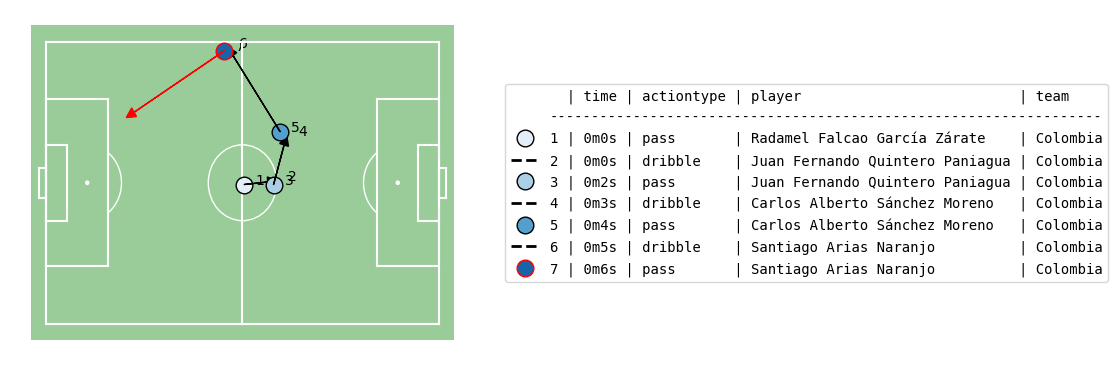

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,player_name,team_name,type_name,result_name,nice_time
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,0.24,769,3445.0,52.9375,33.575,61.6875,34.425,0,1,4,0,Radamel Falcao García Zárate,Colombia,pass,success,0m0s
1,7585,b948f032-4c54-4782-a71a-ffeed8908d00,1,0.48,769,5692.0,61.6875,34.425,60.8125,33.575,21,1,0,1,Juan Fernando Quintero Paniagua,Colombia,dribble,success,0m0s
2,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,1,2.12,769,5692.0,60.8125,33.575,64.3125,45.475,0,1,4,2,Juan Fernando Quintero Paniagua,Colombia,pass,success,0m2s
3,7585,2ffa2904-8b47-4817-af26-aa9ac8d2881a,1,3.44,769,5685.0,64.3125,45.475,62.5625,46.325,21,1,0,3,Carlos Alberto Sánchez Moreno,Colombia,dribble,success,0m3s
4,7585,6cb0d85d-bd14-42e3-9c2d-7f99ce437796,1,4.20,769,5685.0,62.5625,46.325,48.5625,66.725,0,1,5,4,Carlos Alberto Sánchez Moreno,Colombia,pass,success,0m4s
5,7585,e70cdfb1-663c-431d-8a96-8a138a44b5e4,1,5.36,769,5696.0,48.5625,66.725,47.6875,65.875,21,1,0,5,Santiago Arias Naranjo,Colombia,dribble,success,0m5s
6,7585,f8494960-ec60-4fa4-a565-b3c89757e92b,1,6.72,769,5696.0,47.6875,65.875,21.4375,49.725,0,0,5,6,Santiago Arias Naranjo,Colombia,pass,fail,0m6s


In [32]:
# Select the 5 actions preceding the 2-0
shot = 5
a = df_actions[shot-5:shot+2].copy()

# Print the game date and timestamp of the goal
game_id = 7559
g = games[games.game_id == game_id].iloc[0]

plot_actions(a, g)
a

### Expected Threat (xT)


- [Expected Threat 참고 자료](https://karun.in/blog/expected-threat.html)
- xT 계산에 사용되는 액션: pass(cross), dribble, shot(goal)

In [100]:
df_actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,0.240,769,3445.0,52.0625,34.425,43.3125,33.5750,0,1,4,0
1,7585,b948f032-4c54-4782-a71a-ffeed8908d00,1,0.480,769,5692.0,43.3125,33.575,44.1875,34.4250,21,1,0,1
2,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,1,2.120,769,5692.0,44.1875,34.425,40.6875,22.5250,0,1,4,2
3,7585,2ffa2904-8b47-4817-af26-aa9ac8d2881a,1,3.440,769,5685.0,40.6875,22.525,42.4375,21.6750,21,1,0,3
4,7585,6cb0d85d-bd14-42e3-9c2d-7f99ce437796,1,4.200,769,5685.0,42.4375,21.675,56.4375,1.2750,0,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128479,7559,103dd34f-f30c-4afa-8062-beb741bdd69d,2,2943.213,799,5191.0,97.5625,10.625,94.9375,24.2250,0,1,5,2198
128480,7559,690653ec-9d8e-48fc-ae59-8f455e870aed,2,2944.012,799,5173.0,94.9375,24.225,93.1875,23.3750,21,1,0,2199
128481,7559,10507f7e-7b42-4be5-ab60-8f939889b605,2,2944.013,799,5173.0,93.1875,23.375,100.1875,23.3750,0,1,5,2200
128482,7559,84855116-f3ee-4671-b757-b9ce80d79008,2,2945.160,799,5187.0,101.0625,23.375,104.5625,37.1025,11,1,5,2201


In [34]:
A = df_actions.copy()
A["type_name"] = A.type_id.map(spadl.config.actiontypes_df().type_name.to_dict())
A["result_name"] = A.result_id.map(spadl.config.results_df().result_name.to_dict())
A["bodypart_name"] = A.bodypart_id.map(spadl.config.bodyparts_df().bodypart_name.to_dict())

A.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,0.24,769,3445.0,52.0625,34.425,43.3125,33.575,0,1,4,0,pass,success,foot_left
1,7585,b948f032-4c54-4782-a71a-ffeed8908d00,1,0.48,769,5692.0,43.3125,33.575,44.1875,34.425,21,1,0,1,dribble,success,foot
2,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,1,2.12,769,5692.0,44.1875,34.425,40.6875,22.525,0,1,4,2,pass,success,foot_left
3,7585,2ffa2904-8b47-4817-af26-aa9ac8d2881a,1,3.44,769,5685.0,40.6875,22.525,42.4375,21.675,21,1,0,3,dribble,success,foot
4,7585,6cb0d85d-bd14-42e3-9c2d-7f99ce437796,1,4.20,769,5685.0,42.4375,21.675,56.4375,1.275,0,1,5,4,pass,success,foot_right


In [101]:
A["type_name"].value_counts()

pass                56438
dribble             52731
throw_in             2178
take_on              2109
clearance            2074
foul                 1876
tackle               1830
interception         1681
shot                 1556
bad_touch            1547
cross                1305
goalkick              677
freekick_crossed      636
freekick_short        554
corner_crossed        446
keeper_save           326
keeper_claim          174
corner_short          112
keeper_punch           84
shot_freekick          82
shot_penalty           68
Name: type_name, dtype: int64

In [102]:
A[A["type_name"].isin(["pass", "cross", "dribble", "shot"])][["type_name", "result_name"]].value_counts().sort_index()

type_name  result_name
cross      fail             933
           offside            3
           success          369
dribble    success        52731
pass       fail            9782
           offside          125
           success        46531
shot       fail            1427
           success          129
dtype: int64

### xT Model 학습

In [112]:
# 사전 학습된 xT 모델을 로드할 수도 있습니다.
url_grid = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xTModel = xthreat.load_model(url_grid)

In [113]:
print(f"xT shape: {xTModel.xT.shape}")
xTModel.xT

xT shape: (8, 12)


array([[0.00638303, 0.00779616, 0.00844854, 0.00977659, 0.01126267,
        0.01248344, 0.01473596, 0.0174506 , 0.02122129, 0.02756312,
        0.03485072, 0.0379259 ],
       [0.00750072, 0.00878589, 0.00942382, 0.0105949 , 0.01214719,
        0.0138454 , 0.01611813, 0.01870347, 0.02401521, 0.02953272,
        0.04066992, 0.04647721],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138, 0.06442595],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138,

In [114]:
# 16x12 그리드로 xT 모델을 초기화하고 학습시킵니다
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(A)

# iterations:  44


In [115]:
print(f"xT shape: {xTModel.xT.shape}")
xTModel.xT

xT shape: (12, 16)


array([[0.00194976, 0.00251334, 0.00272419, 0.00352568, 0.00438911,
        0.0051197 , 0.00585738, 0.00665859, 0.0078213 , 0.00899081,
        0.01069718, 0.01243556, 0.01470712, 0.01611302, 0.01668612,
        0.01399012],
       [0.00192454, 0.0026353 , 0.00331917, 0.00439719, 0.00475394,
        0.0055342 , 0.00655667, 0.00724257, 0.00832973, 0.00969943,
        0.01167588, 0.01327214, 0.0161399 , 0.01697883, 0.01866793,
        0.01823837],
       [0.00210529, 0.00326333, 0.00387024, 0.00453421, 0.00531841,
        0.00601875, 0.0067807 , 0.00773209, 0.0091481 , 0.01019711,
        0.01189371, 0.01364283, 0.016567  , 0.02105214, 0.02366795,
        0.01977966],
       [0.00281484, 0.00335804, 0.00402262, 0.00470739, 0.0055    ,
        0.00638828, 0.0070558 , 0.00814164, 0.00927998, 0.01075883,
        0.01274261, 0.01459036, 0.02035589, 0.02968627, 0.02740551,
        0.03416092],
       [0.00260472, 0.0036457 , 0.00412526, 0.00487661, 0.00566582,
        0.00641655, 0.00724984, 

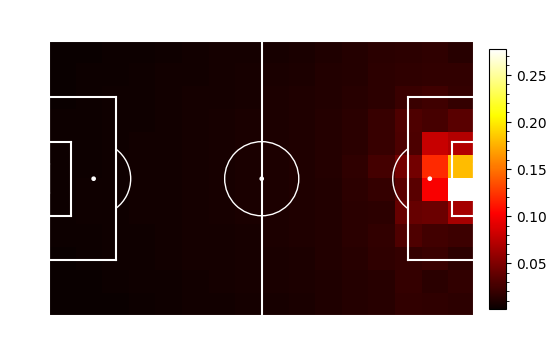

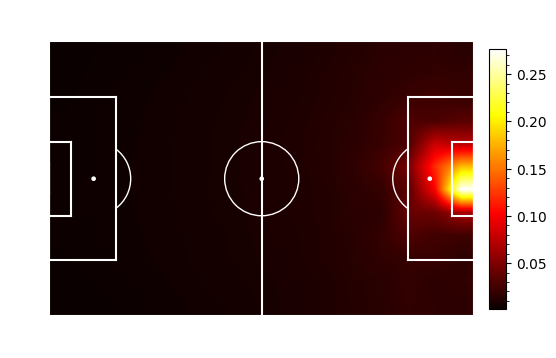

<Axes: >

In [116]:
# 학습된 xT 값을 히트맵으로 시각화.
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")


# 그리드 셀 사이의 값을 부드럽게 보간(interpolate)하여 경기장 내 모든의 좌표 (x, y)에서의 xT 값을 추정.
# 경기장 전체 크기(105x68)에 맞춰 세밀한 좌표 그리드를 생성합니다. (105 x 68)
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [117]:
# xT 값은 공을 성공적으로 이동시키고 소유권을 유지한 액션에 대해서만 평가.
mov_actions = xthreat.get_successful_move_actions(A)

# rate: xT_value = xT(end_location) - xT(start_location)
mov_actions["xT_value"] = xTModel.rate(mov_actions)
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

,type_name,start_x,start_y,end_x,end_y,xT_value
0,pass,52.0625,34.425,43.3125,33.575,-0.000840
1,dribble,43.3125,33.575,44.1875,34.425,-0.000251
2,pass,44.1875,34.425,40.6875,22.525,-0.000466
3,dribble,40.6875,22.525,42.4375,21.675,0.000000
4,pass,42.4375,21.675,56.4375,1.275,0.001023
5,dribble,56.4375,1.275,57.3125,2.125,0.000000
7,pass,21.4375,49.725,27.5625,66.725,-0.000318
9,dribble,83.5625,14.025,82.6875,14.025,0.000000
10,pass,82.6875,14.025,80.0625,3.825,-0.003529
11,dribble,80.0625,3.825,77.4375,12.325,-0.000081


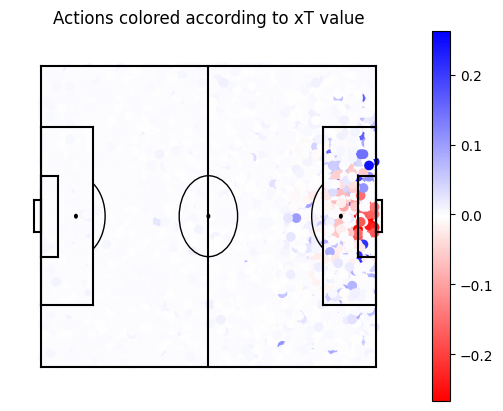

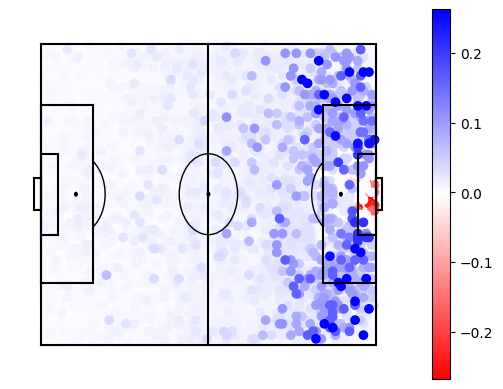

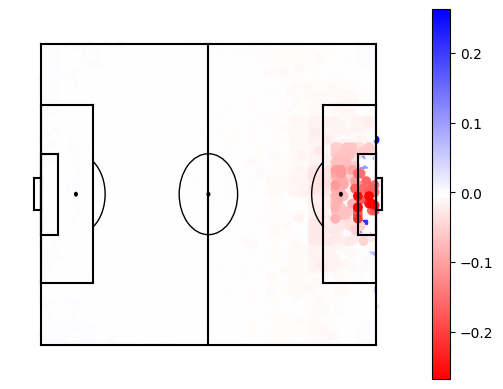

In [ ]:
# xT 값 분포를 시각화하여 액션들의 가치 평가 경향을 확인합니다.
a = mov_actions.copy()

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# xT 값이 낮은 액션
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# xT 값이 높은 액션
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

In [ ]:
# xT 모델 학습 과정(Value Iteration)의 각 단계별 xT 값 변화를 3D Surface 플롯으로 시각화하는 함수
def visualize_surface_plots(xTModel):
	"""Visualizes the surface plot of each iteration of the model.

	See https://plot.ly/python/sliders/ and https://karun.in/blog/expected-threat.html#visualizing-xt
	NOTE: y-axis is mirrored in plotly.
	"""
	camera = dict(
		up=dict(x=0, y=0, z=1),
		center=dict(x=0, y=0, z=0),
		eye=dict(x=-2.25, y=-1, z=0.5),
	)

	max_z = np.around(xTModel.xT.max() + 0.05, decimals=1)

	layout = go.Layout(
		title="Expected Threat",
		autosize=True,
		width=500,
		height=500,
		margin=dict(l=65, r=50, b=65, t=90),
		scene=dict(
			camera=camera,
			aspectmode="auto",
			xaxis=dict(),
			yaxis=dict(),
			zaxis=dict(autorange=False, range=[0, max_z]),
		),
	)

	fig = go.Figure(layout=layout)

	for i in xTModel.heatmaps:
		fig.add_trace(go.Surface(z=i))

	# Make last trace visible
	for i in range(len(fig.data) - 1):
		fig.data[i].visible = False
	fig.data[len(fig.data) - 1].visible = True

	# Create and add slider
	steps = []
	for i in range(len(fig.data)):
		step = dict(method="restyle", args=["visible", [False] * len(fig.data)])
		step["args"][1][i] = True  # Toggle i'th trace to "visible"
		steps.append(step)

	sliders = [
		dict(
			active=(len(fig.data) - 1),
			currentvalue={"prefix": "Iteration: "},
			pad={"t": 50},
			steps=steps,
		)
	]

	fig.update_layout(sliders=sliders)
	fig.show()
	
visualize_surface_plots(xTModel)

### 2018 월드컵 최고 xT 플레이 분석

In [119]:
mov_actions.sort_values("xT_value", ascending=False).head(10)

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT_value
73823,7584,69216fe5-4f6d-41fc-8f2d-a52b5cfe6ea0,2,1002.860,782,3176.0,98.4375,5.525,100.1875,30.175,1,1,5,1523,cross,success,foot_right,0.262286
8291,7542,5f7c5725-a8c4-49b3-a845-2549ec44bdd2,1,233.500,780,3168.0,101.0625,2.125,99.3125,33.575,1,1,5,88,cross,success,foot_right,0.262286
82647,7531,52b22ee1-de3f-41ee-9434-f861b978ebb0,1,2382.873,779,5510.0,101.9375,14.875,101.9375,28.475,21,1,0,931,dribble,success,foot,0.261819
101809,7577,d3bd8444-b2ba-416b-b053-5338d5f67f57,2,2106.260,788,5245.0,87.0625,64.175,99.3125,33.575,1,1,5,1386,cross,success,foot_right,0.261815
36891,7576,370770f1-183c-442d-bf1a-e58ab47ddd0d,2,2799.773,780,4272.0,83.5625,59.075,98.4375,30.175,1,1,5,2264,cross,success,foot_right,0.261788
72965,7584,d8a2b5ef-8d78-48dc-94bb-9380531ddba0,1,1642.640,782,3089.0,81.8125,59.925,101.9375,28.475,1,1,5,665,cross,success,foot_right,0.261788
82705,7531,498bfef1-9b1f-48f9-b595-d43466463af3,1,2566.740,793,3720.0,86.1875,1.275,100.1875,28.475,21,1,0,989,dribble,success,foot,0.260062
54995,7534,d07fa937-0d02-405b-9c58-398e6e66e01c,2,2515.267,770,5579.0,88.8125,4.675,99.3125,32.725,1,1,5,1897,cross,success,foot_right,0.260062
68870,7547,08be30d4-c889-44bf-adbb-e6178d95c35d,1,1415.840,776,4763.0,91.4375,3.825,99.3125,32.725,1,1,5,506,cross,success,foot_right,0.260062
40309,7551,c03287fa-8086-4a7f-88f3-02c50c593a3e,2,233.693,770,5579.0,102.8125,8.075,99.3125,28.475,1,1,5,1098,cross,success,foot_right,0.259844


2018-07-02 20:00:00 Belgium 3-2 Japan 62'


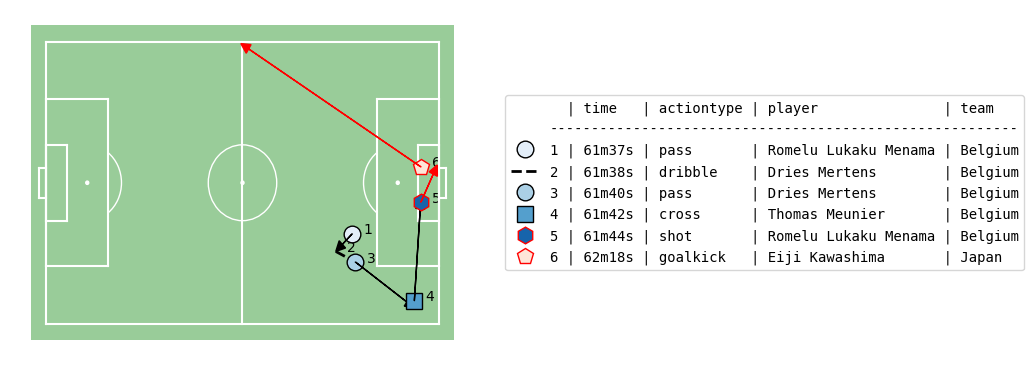

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT_value,player_name,team_name,nice_time
73820,7584,c4164945-f28f-4bb0-bfe0-a46f72314e85,2,997.980,782,3289.0,81.8125,21.675,77.4375,17.4250,0,1,4,1520,pass,success,foot_left,-0.004265,Romelu Lukaku Menama,Belgium,61m37s
73821,7584,5adcd48c-f31f-43e3-84c2-8b4959be28c0,2,998.913,782,5630.0,77.4375,17.425,82.6875,14.8750,21,1,0,1521,dribble,success,foot,0.003001,Dries Mertens,Belgium,61m38s
73822,7584,6be0ecdb-87b0-4aa2-ab60-7223bb4ce0ad,2,1000.260,782,5630.0,82.6875,14.875,98.4375,3.8250,0,1,5,1522,pass,success,foot_right,-0.001860,Dries Mertens,Belgium,61m40s
73823,7584,69216fe5-4f6d-41fc-8f2d-a52b5cfe6ea0,2,1002.860,782,3176.0,98.4375,5.525,100.1875,30.1750,1,1,5,1523,cross,success,foot_right,0.262286,Thomas Meunier,Belgium,61m42s
73824,7584,da38978f-a465-438e-b243-f71046a50368,2,1004.020,782,3289.0,100.1875,29.325,104.5625,38.2925,11,0,1,1524,shot,fail,head,NaN,Romelu Lukaku Menama,Belgium,61m44s
73825,7584,f38f2661-b11e-4095-b4b2-b9d6ad4bcd50,2,1038.860,778,3175.0,100.1875,37.825,52.0625,67.5750,22,0,5,1525,goalkick,fail,foot_right,NaN,Eiji Kawashima,Japan,62m18s


In [120]:
# Select the 5 actions preceding the 2-0
xT_A = pd.concat([A, mov_actions[["xT_value"]]], axis=1)
high_xT_play_idx = xT_A.sort_values("xT_value", ascending=False).iloc[0].name
a = xT_A[high_xT_play_idx-3:high_xT_play_idx+3].copy()

# Print the game date and timestamp of the goal
game_id = a.iloc[0].game_id
g = games[games.game_id == game_id].iloc[0]

plot_actions(a, g)
a

### 선수별 xT 평가

In [47]:
df_player_games

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7585,768,3094,Bamidele Alli,Dele Alli,20,True,20,Left Attacking Midfield,84
1,7585,768,3205,Kyle Walker,None,2,True,3,Right Center Back,123
2,7585,768,3233,Raheem Sterling,Raheem Sterling,10,True,22,Right Center Forward,91
3,7585,768,3244,John Stones,None,5,True,4,Center Back,132
4,7585,768,3293,Jesse Lingard,None,7,True,18,Right Attacking Midfield,132
...,...,...,...,...,...,...,...,...,...,...
1785,7559,799,5191,Mohammed Al Burayk,None,6,True,2,Right Back,101
1786,7559,799,5192,Yehya Sulaiman Ali Al-Shehri,Yehya Al Shehri,8,False,0,Substitute,17
1787,7559,799,5716,Hussain Al Mogahwi,None,16,True,13,Right Center Midfield,101
1788,7559,799,6290,Motaz Ali Hassan Hawsawi,Motaz Hawsawi,23,True,5,Left Center Back,101


In [76]:
df_player_info = df_player_games.groupby("player_id").agg(
	total_minutes_played=("minutes_played", "sum"),
	num_games=("game_id", "nunique"),
	main_position=("starting_position_name", lambda x: x.mode()[0])
).reset_index(drop=False)
df_player_info

,player_id,total_minutes_played,num_games,main_position
0,2941,332,3,Right Wing
1,2948,144,6,Substitute
2,2954,189,4,Substitute
3,2974,97,1,Left Center Midfield
4,2995,291,3,Left Midfield
...,...,...,...,...
599,19597,96,1,Left Midfield
600,19988,24,1,Substitute
601,20004,619,6,Left Center Midfield
602,20005,577,6,Right Center Back


In [77]:
mov_actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,xT_value
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,0.240,769,3445.0,52.0625,34.425,43.3125,33.575,0,1,4,0,pass,success,foot_left,-0.000840
1,7585,b948f032-4c54-4782-a71a-ffeed8908d00,1,0.480,769,5692.0,43.3125,33.575,44.1875,34.425,21,1,0,1,dribble,success,foot,-0.000251
2,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,1,2.120,769,5692.0,44.1875,34.425,40.6875,22.525,0,1,4,2,pass,success,foot_left,-0.000466
3,7585,2ffa2904-8b47-4817-af26-aa9ac8d2881a,1,3.440,769,5685.0,40.6875,22.525,42.4375,21.675,21,1,0,3,dribble,success,foot,0.000000
4,7585,6cb0d85d-bd14-42e3-9c2d-7f99ce437796,1,4.200,769,5685.0,42.4375,21.675,56.4375,1.275,0,1,5,4,pass,success,foot_right,0.001023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128476,7559,92dc1750-688d-4efa-8355-12c2d7097732,2,2941.413,799,5187.0,101.0625,18.275,101.9375,18.275,21,1,0,2195,dribble,success,foot,0.000000
128479,7559,103dd34f-f30c-4afa-8062-beb741bdd69d,2,2943.213,799,5191.0,97.5625,10.625,94.9375,24.225,0,1,5,2198,pass,success,foot_right,0.026960
128480,7559,690653ec-9d8e-48fc-ae59-8f455e870aed,2,2944.012,799,5173.0,94.9375,24.225,93.1875,23.375,21,1,0,2199,dribble,success,foot,0.000000
128481,7559,10507f7e-7b42-4be5-ab60-8f939889b605,2,2944.013,799,5173.0,93.1875,23.375,100.1875,23.375,0,1,5,2200,pass,success,foot_right,0.023989


In [ ]:
# Compute each player's number of actions and total xT values
mov_actions["xT_count"] = 1

playersR = (
    mov_actions[["player_id", "xT_value", "xT_count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

playersR["player_name"] = playersR.player_id.map(df_players.set_index("player_id").player_name)
playersR["team_id"] = playersR.player_id.map(df_players.set_index("player_id").team_id)
playersR["team_name"] = playersR.team_id.map(df_teams.set_index("team_id").team_name)
playersR.sort_values("xT_value", ascending=False).head(10)

,player_id,xT_value,xT_count,player_name,team_id,team_name
122,4320.0,1.798915,559,Neymar da Silva Santos Junior,781,Brazil
357,5579.0,1.612718,435,Joshua Kimmich,770,Germany
17,3089.0,1.332165,561,Kevin De Bruyne,782,Belgium
92,3621.0,1.175102,541,Eden Hazard,782,Belgium
26,3176.0,1.011322,361,Thomas Meunier,782,Belgium
174,5209.0,0.996554,349,Raphaël Adelino José Guerreiro,780,Portugal
599,20004.0,0.970554,537,Paul Pogba,771,France
248,5470.0,0.940600,668,Ivan Rakitić,785,Croatia
352,5574.0,0.910934,564,Toni Kroos,770,Germany
71,3501.0,0.848080,604,Philippe Coutinho Correia,781,Brazil


In [98]:
playersR.total_minutes_played.describe()

count    602.000000
mean     235.031561
std      159.803834
min        3.000000
25%       98.000000
50%      226.000000
75%      301.500000
max      741.000000
Name: total_minutes_played, dtype: float64

In [99]:
# Normalize for minutes played

playersR["total_minutes_played"] = playersR.player_id.map(df_player_info.set_index("player_id").total_minutes_played)
playersR["xT_per_90"] = playersR.xT_value * 90 / playersR.total_minutes_played
playersR[playersR.total_minutes_played > 235].sort_values("xT_per_90", ascending=False).head(10) # at least 235 minutes played (mean 235 minutes)

,player_id,xT_value,xT_count,player_name,team_id,team_name,total_minutes_played,xT_per_90
357,5579.0,1.612718,435,Joshua Kimmich,770,Germany,295,0.492016
122,4320.0,1.798915,559,Neymar da Silva Santos Junior,781,Brazil,483,0.335202
352,5574.0,0.910934,564,Toni Kroos,770,Germany,295,0.277912
108,3831.0,0.740312,145,Dušan Tadić,786,Serbia,274,0.243168
174,5209.0,0.996554,349,Raphaël Adelino José Guerreiro,780,Portugal,389,0.230565
330,5552.0,0.751565,493,Marcelo Vieira da Silva Júnior,781,Brazil,302,0.223976
179,5216.0,0.720434,491,Andrés Iniesta Luján,772,Spain,300,0.216130
134,4831.0,0.816646,301,Nacer Chadli,782,Belgium,341,0.215537
17,3089.0,1.332165,561,Kevin De Bruyne,782,Belgium,577,0.207790
94,3632.0,0.580376,206,André Martín Carrillo Díaz,784,Peru,271,0.192745
